In [48]:
import heapq
from sklearn.datasets import make_blobs
import math

from PIL import Image
import numpy as np


import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_blobs
import networkx as nx

In [49]:
# Load the image

image_path = "images/xmas.png"  # Replace with your image path
image = Image.open(image_path)
image = image.convert("RGB")  # Ensure image is in RGB mode

# Get image dimensions
width, height = image.size

# Extract pixel values and store as RGB points
rgb_points = []
for y in range(height):
    for x in range(width):
        r, g, b = image.getpixel((x, y))
        rgb_points.append((r, g, b))


points = list(set(rgb_points))

In [50]:


class KDNode:
    def __init__(self, point, axis, left=None, right=None):
        self.point = point
        self.axis = axis
        self.left = left
        self.right = right


class KDTree:
    def __init__(self):
        self.root = None

    def build(self, points, depth=0):
        if not points:
            return None

        k = len(points[0])
        axis = depth % k

        points.sort(key=lambda x: x[axis])
        median = len(points) // 2

        return KDNode(
            point=points[median],
            axis=axis,
            left=self.build(points[:median], depth + 1),
            right=self.build(points[median + 1 :], depth + 1),
        )

    def insert(self, point):
        def _insert_rec(node, point, depth=0):
            if node is None:
                k = len(point)
                return KDNode(point, depth % k)

            if point[node.axis] < node.point[node.axis]:
                node.left = _insert_rec(node.left, point, depth + 1)
            else:
                node.right = _insert_rec(node.right, point, depth + 1)

            return node

        self.root = _insert_rec(self.root, point)


def i_neighbors(tree, query_point, i):
    if tree.root is None:
        return None
    i += 1
    neighbors = []
    visited = set()

    def _search(node):
        if node is None or node in visited:
            return

        visited.add(node)

        distance = sum([(a - b) ** 2 for a, b in zip(node.point, query_point)]) ** 0.5

        if len(neighbors) < i:
            heapq.heappush(neighbors, (-distance, node.point))
        else:
            if distance < -neighbors[0][0]:
                heapq.heappop(neighbors)
                heapq.heappush(neighbors, (-distance, node.point))

        axis = node.axis
        next_branch = node.left if query_point[axis] < node.point[axis] else node.right
        opposite_branch = (
            node.right if query_point[axis] < node.point[axis] else node.left
        )

        _search(next_branch)

        if (
            len(neighbors) < i
            or abs(query_point[axis] - node.point[axis]) < -neighbors[0][0]
        ):
            _search(opposite_branch)

    _search(tree.root)
    neighbors.sort(key=lambda x: -x[0])
    neighbors = [(-d, p) for d, p in neighbors]
    return neighbors[1 : i + 1]


def brute_force_neighbors(points, query_point, i):
    distances = []
    for point in points:
        distance = sum([(a - b) ** 2 for a, b in zip(point, query_point)]) ** 0.5
        distances.append((distance, point))
    distances.sort(key=lambda x: x[0])
    return distances[1 : i + 1]


def verify_kd_tree(tree, points, query_point, i):
    kd_neighbors = i_neighbors(tree, query_point, i)
    bf_neighbors = brute_force_neighbors(points, query_point, i)

    kd_points = [p for _, p in kd_neighbors]
    bf_points = [p for _, p in bf_neighbors]

    return kd_points == bf_points



In [51]:
def euclidean_distance(point1, point2):
    return math.sqrt(sum((x - y) ** 2 for x, y in zip(point1, point2)))

In [52]:
def plot_3d_graph(G):
    pos = nx.get_node_attributes(G, "pos")
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    for edge in G.edges():
        x = [pos[edge[0]][0], pos[edge[1]][0]]
        y = [pos[edge[0]][1], pos[edge[1]][1]]
        z = [pos[edge[0]][2], pos[edge[1]][2]]
        ax.plot(x, y, z, color="b")

    xs = [pos[key][0] for key in pos]
    ys = [pos[key][1] for key in pos]
    zs = [pos[key][2] for key in pos]
    ax.scatter(xs, ys, zs, c="r", marker="o")

    ax.set_xlabel("X Axis")
    ax.set_ylabel("Y Axis")
    ax.set_zlabel("Z Axis")
    plt.title("3D NetworkX Graph")
    plt.show()

In [53]:
def round_coordinates(points, decimals=1):
    return [tuple(round(coord, decimals) for coord in point) for point in points]

In [54]:
# Install dependencies (uncomment and run in a terminal or notebook cell)

# Generate 3D points with 3 clusters
# n_samples = 50
# n_features = 3
# n_clusters = 1

# X, y = make_blobs(
#     n_samples=n_samples, n_features=n_features, centers=n_clusters, random_state=42
# )

# points = [tuple(point) for point in X.tolist()]
# points = round_coordinates(points, decimals=1)
maxdis = math.ceil(math.log2(len(points)))

In [55]:
def build():
    tree = KDTree()

    tree.root = tree.build(points)

    # NetworkX graph construction
    G = nx.Graph()
    for point in points:
        G.add_node(tuple(point), pos=tuple(point))

    neighbours = {}
    
    for point in points:
        neighbours[point] = i_neighbors(tree, point, maxdis)
    return G, neighbours

In [56]:
G, neighbours = build()
print(G.number_of_nodes(), G.number_of_edges())
k = 0
while k < maxdis:

    print("Connected Components : ", len(list(nx.connected_components(G))))
    if (len(connected_components := list(nx.connected_components(G)))) == 1:
        break
    print(
            f"The graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges."
        )
    for component in connected_components:
        for node in component:
            wt, pos = neighbours[node][k]
            if pos in component:
                continue
            # print(f"Adding edge between {node} and {pos} with weight {wt}")
            G.add_edge(node, pos, weight=wt)
    k += 1
    # plot_3d_graph(G)
print(G.number_of_nodes(), G.number_of_edges())

8544 0
Connected Components :  8544
The graph has 8544 nodes and 0 edges.
Connected Components :  1897
The graph has 8544 nodes and 6657 edges.
Connected Components :  75
The graph has 8544 nodes and 10180 edges.
Connected Components :  9
The graph has 8544 nodes and 10412 edges.
Connected Components :  1
8544 10433


In [57]:
neighbours

{(0, 2, 5): [(1.7320508075688772, (1, 1, 4)),
  (3.7416573867739413, (3, 0, 4)),
  (5.385164807134504, (0, 4, 10)),
  (6.164414002968976, (5, 0, 2)),
  (6.4031242374328485, (1, 4, 11)),
  (7.14142842854285, (7, 1, 4)),
  (7.681145747868608, (1, 5, 12)),
  (8.06225774829855, (6, 0, 0)),
  (8.12403840463596, (8, 1, 4)),
  (8.602325267042627, (4, 5, 12)),
  (9.1104335791443, (5, 5, 12)),
  (22.561028345356956, (22, 2, 0)),
  (28.442925306655784, (28, 2, 0)),
  (28.91366458960192, (8, 16, 29))],
 (0, 4, 10): [(1.4142135623730951, (1, 4, 11)),
  (2.449489742783178, (1, 5, 12)),
  (4.58257569495584, (4, 5, 12)),
  (5.385164807134504, (0, 2, 5)),
  (5.477225575051661, (5, 5, 12)),
  (6.782329983125268, (1, 1, 4)),
  (7.810249675906654, (3, 0, 4)),
  (9.695359714832659, (7, 1, 4)),
  (10.246950765959598, (5, 0, 2)),
  (10.44030650891055, (8, 1, 4)),
  (12.328828005937952, (6, 0, 0)),
  (23.853720883753127, (8, 16, 29)),
  (24.24871130596428, (22, 2, 0)),
  (25.787593916455254, (5, 12, 34))],
 

8544 8543


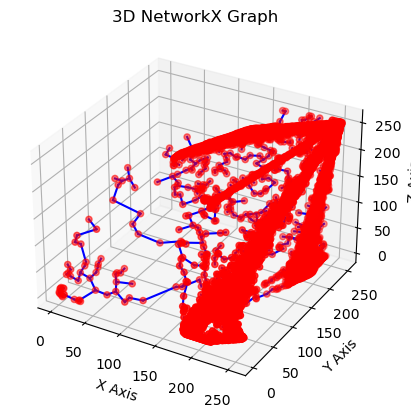

In [58]:
mst = nx.minimum_spanning_tree(G)
print(mst.number_of_nodes(), mst.number_of_edges())
plot_3d_graph(mst)

In [59]:
for node, attr in G.nodes(data=True):
    print(f"Point: {node}, Position: {attr['pos']}")

Point: (0, 2, 5), Position: (0, 2, 5)
Point: (0, 4, 10), Position: (0, 4, 10)
Point: (1, 4, 11), Position: (1, 4, 11)
Point: (1, 5, 12), Position: (1, 5, 12)
Point: (1, 1, 4), Position: (1, 1, 4)
Point: (3, 0, 4), Position: (3, 0, 4)
Point: (4, 5, 12), Position: (4, 5, 12)
Point: (5, 12, 34), Position: (5, 12, 34)
Point: (5, 5, 12), Position: (5, 5, 12)
Point: (5, 16, 34), Position: (5, 16, 34)
Point: (5, 0, 2), Position: (5, 0, 2)
Point: (6, 14, 52), Position: (6, 14, 52)
Point: (6, 0, 0), Position: (6, 0, 0)
Point: (7, 1, 4), Position: (7, 1, 4)
Point: (8, 16, 29), Position: (8, 16, 29)
Point: (8, 1, 4), Position: (8, 1, 4)
Point: (10, 14, 44), Position: (10, 14, 44)
Point: (10, 26, 88), Position: (10, 26, 88)
Point: (11, 29, 99), Position: (11, 29, 99)
Point: (13, 34, 80), Position: (13, 34, 80)
Point: (14, 52, 115), Position: (14, 52, 115)
Point: (18, 18, 23), Position: (18, 18, 23)
Point: (18, 23, 35), Position: (18, 23, 35)
Point: (21, 29, 45), Position: (21, 29, 45)
Point: (22, 

In [60]:
total_weight = 0
print("\nEdges in the MST and their weights (calculated manually):")
for edge in mst.edges():
    point1, point2 = edge
    weight = euclidean_distance(point1, point2)
    print(f"Edge: {point1} - {point2}, Weight: {weight}")
    total_weight += weight

print(f"\nTotal weight of the Minimum Spanning Tree: {total_weight}")


Edges in the MST and their weights (calculated manually):
Edge: (0, 2, 5) - (1, 1, 4), Weight: 1.7320508075688772
Edge: (0, 2, 5) - (0, 4, 10), Weight: 5.385164807134504
Edge: (0, 4, 10) - (1, 4, 11), Weight: 1.4142135623730951
Edge: (1, 4, 11) - (1, 5, 12), Weight: 1.4142135623730951
Edge: (1, 5, 12) - (4, 5, 12), Weight: 3.0
Edge: (1, 1, 4) - (3, 0, 4), Weight: 2.23606797749979
Edge: (3, 0, 4) - (5, 0, 2), Weight: 2.8284271247461903
Edge: (4, 5, 12) - (5, 5, 12), Weight: 1.0
Edge: (5, 12, 34) - (5, 16, 34), Weight: 4.0
Edge: (5, 16, 34) - (8, 16, 29), Weight: 5.830951894845301
Edge: (5, 16, 34) - (10, 14, 44), Weight: 11.357816691600547
Edge: (5, 0, 2) - (6, 0, 0), Weight: 2.23606797749979
Edge: (5, 0, 2) - (7, 1, 4), Weight: 3.0
Edge: (6, 14, 52) - (10, 14, 44), Weight: 8.94427190999916
Edge: (7, 1, 4) - (8, 1, 4), Weight: 1.0
Edge: (8, 16, 29) - (18, 18, 23), Weight: 11.832159566199232
Edge: (8, 1, 4) - (22, 2, 0), Weight: 14.594519519326424
Edge: (10, 26, 88) - (11, 29, 99), Weig

In [61]:
complete_graph = nx.Graph()
for point in points:
    complete_graph.add_node(point, pos=point)

# Add edges with Euclidean distance as weights
for i, point1 in enumerate(points):
    for j, point2 in enumerate(points):
        if i != j:
            distance = euclidean_distance(point1, point2)
            complete_graph.add_edge(point1, point2, weight=distance)

# Print points and their positions
print("Points and their positions in the graph:")
for node, attr in complete_graph.nodes(data=True):
    print(f"Point: {node}, Position: {attr['pos']}")

# Calculate the MST using NetworkX's minimum_spanning_tree function
mst_graph = nx.minimum_spanning_tree(complete_graph)

# Calculate the total weight of the MST
total_weight = 0
print("\nEdges in the MST and their weights:")
for edge in mst_graph.edges(data=True):
    print(f"Edge: {edge[0]} - {edge[1]}, Weight: {edge[2]['weight']}")
    total_weight += edge[2]["weight"]

print(f"\nTotal weight of the Minimum Spanning Tree: {total_weight}")

KeyboardInterrupt: 

In [ ]:
len((points))

50